# Syntheteic Data

In [194]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
import sys

# append the path of the package to the sys.path
sys.path.append('/sep/haipeng/FWI/seisfwi/')

In [196]:
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from IPython.display import HTML
from tqdm.notebook import tqdm
import matplotlib.gridspec as gridspec

from seisfwi.model import ElasticModel, ElasticModelRBF
from seisfwi.survey import Survey, Source, Receiver, SeismicData, GenericCable
from seisfwi.propagator import ElasticPropagator
from seisfwi.problem import ElasticFWI, WaveformL2Loss, GCLoss
from seisfwi.utils import wavelet, smooth2d, load_misfit
from seisfwi.utils import gmsh_center2d, set_sigma, RBF, interp_data2d
from seisfwi.problem import AcousticInference, AcousticLikelihood, UniformPrior, GaussianPrior
from seisfwi.view import plot_misfit

import arviz as az
import cassm_utils
import plots

In [197]:
# path
path = f'AGU-Elastic-Simple'
os.makedirs(path, exist_ok=True)
os.makedirs(f'{path}/Figure', exist_ok=True)

# Plotting
cmap_range = {'vp': (3000, 4500)}
cmap_range_co2 = {'vp': (-125, 125)}
# cmap_range_co2 = {'vp': (-50, 50)}

plot_args = {
    "orientation": 'vertical',
    "cmap_range": cmap_range ,
    "aspect": 'equal'
}

plot_args_4d = {
    "orientation": 'vertical',
    "cmap_range": cmap_range_co2 ,
    "aspect": 'equal'
}


font_paths = [
    '/homes/sep/haipeng/.local/share/fonts/Helvetica.ttf',
    '/homes/sep/haipeng/.local/share/fonts/Helvetica-Bold.ttf',
    '/homes/sep/haipeng/.local/share/fonts/Helvetica-Oblique.ttf',
    '/homes/sep/haipeng/.local/share/fonts/Helvetica-BoldOblique.ttf'
]
for font_path in font_paths:
    fm.fontManager.addfont(font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 12})

## Seismic Models and Survey Geometry

In [198]:
# Modeling parameters
ox = 0.0
oz = 0.0
nx = 101
nz = 101
dx = 10.0
dz = 10.0

# True model for modeling obs data (after oil extraction)
vp_bl = np.ones((nz, nx)) * 4000
vs_bl = np.ones((nz, nx)) * 2300
rho_bl = np.ones((nz, nx)) * 2500

x = np.arange(ox, nx*dx, dx)
z = np.arange(oz, nz*dz, dz)

In [199]:
model_bl = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp_bl, vs=vs_bl, rho=rho_bl, 
                        free_surface=False, nabc=20) # , device='cuda'          

In [200]:
## Define the source and receiver
nt = 800
dt = 0.001
f0 = 15.0
amp = 1e7

# Source
source = Source(nt = nt, dt = dt, f0 = f0)

wvlt = wavelet(nt, dt, f0) * amp
wvlt = np.diff(wvlt, prepend=0)
wvlt = np.diff(wvlt, prepend=0)
wvlt = -1.0 * wvlt
        
for isrc in range(5):
    source.add_source([100, 200 * isrc + 100], wvlt, 'vx')

# Create a set of seismic receiver. Not DAS
geophone = Receiver(nt = nt, dt = dt)
for irec in range(nz-10):
    geophone.add_receiver([900, dx * (irec + 5)], 'vx')
    geophone.add_receiver([900, dx * (irec + 5)], 'vz')


# Define the survey
survey = Survey(source=source, receiver=geophone, device='cuda', gpu_num=1)

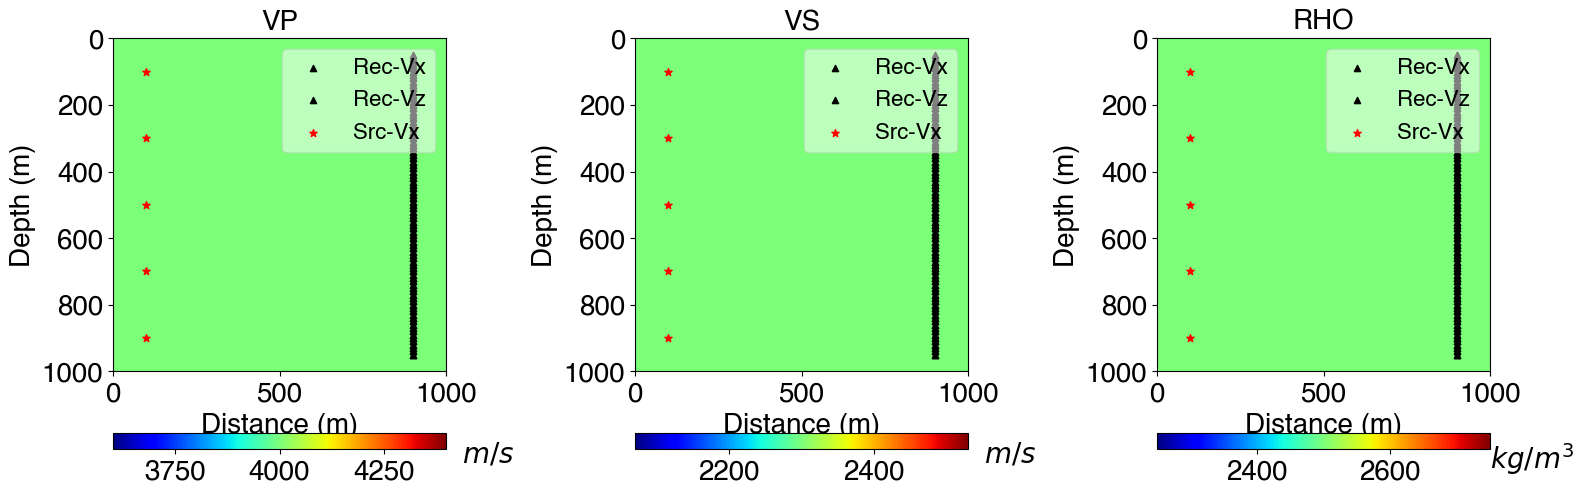

In [201]:
model_bl.plot(survey, fontsize=20, save_path=f'{path}/Figure/true_model_bl.pdf')

In [202]:
rbf_center = np.array([
       [ 300.0, 400.0],
       [ 700.0, 400.0],
       [ 300.0, 700.0],
       [ 700.0, 700.0],
       ])

sigma = set_sigma(rbf_center, 0.3)


theta_vp_true = np.zeros(len(rbf_center))
theta_vp_true[0] = -100.0
theta_vp_true[1] =  100.0
theta_vp_true[2] =  60.0
theta_vp_true[3] = -60.0

theta_vs_true = np.zeros(len(rbf_center))
theta_vs_true[0] =  100.0/1.7
theta_vs_true[1] = -100.0/1.7
theta_vs_true[2] = -60.0/1.7
theta_vs_true[3] =  60.0/1.7

theta_rho_true = np.zeros(len(rbf_center))
theta_rho_true[0] = -100.0/1.5
theta_rho_true[1] =  100.0/1.5
theta_rho_true[2] =  60.0/1.5
theta_rho_true[3] = -60.0/1.5


In [203]:
model_ml = ElasticModelRBF(ox, oz, dx, dz, nx, nz, 
                           centers = rbf_center, 
                           theta_vp = theta_vp_true, 
                           theta_vs = theta_vs_true,
                           theta_rho = theta_rho_true,
                           sigma = sigma,
                           vp = vp_bl,
                           vs = vs_bl,
                           rho = rho_bl,
                           device='cuda')

vp_ml = model_ml.get_model('vp')
vs_ml = model_ml.get_model('vs')
rho_ml = model_ml.get_model('rho')

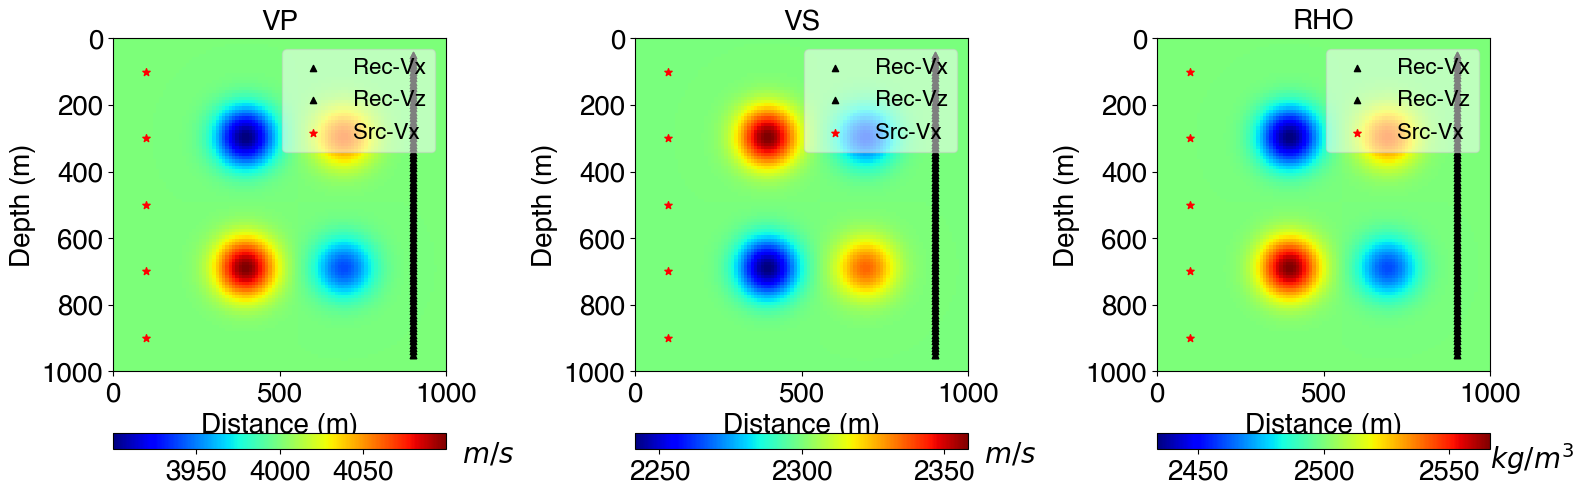

In [204]:
model_ml.plot(survey, fontsize=20, save_path=f'{path}/Figure/true_model_ml.pdf')

## OBS data 

In [205]:
F = ElasticPropagator(model_bl, survey)
dobs_bl = F(model_bl)
dobs_ml = F(model_ml)
# dobs_bl.save(f'{path}/dobs_bl.npy')
# dobs_ml.save(f'{path}/dobs_ml.npy')

Survey analysis completed: legal survey
free surface: False


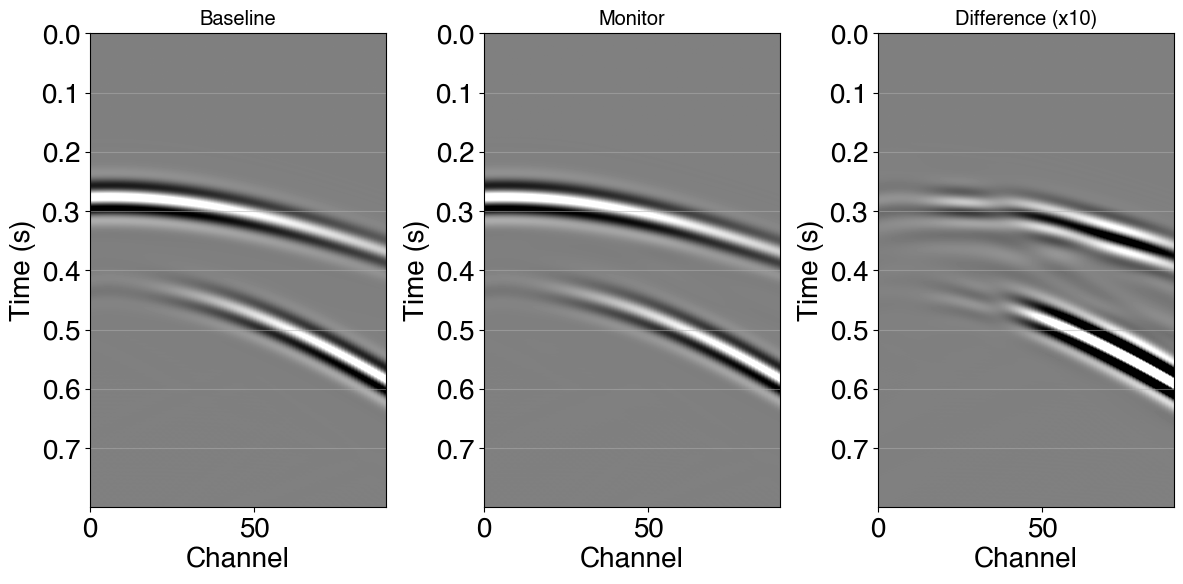

In [206]:
dobs_bl.plot_compare(dobs_ml, shotid=0, comp='vx', clip=99., ratio=10, 
                     title=['Baseline', 'Monitor', 'Difference'])

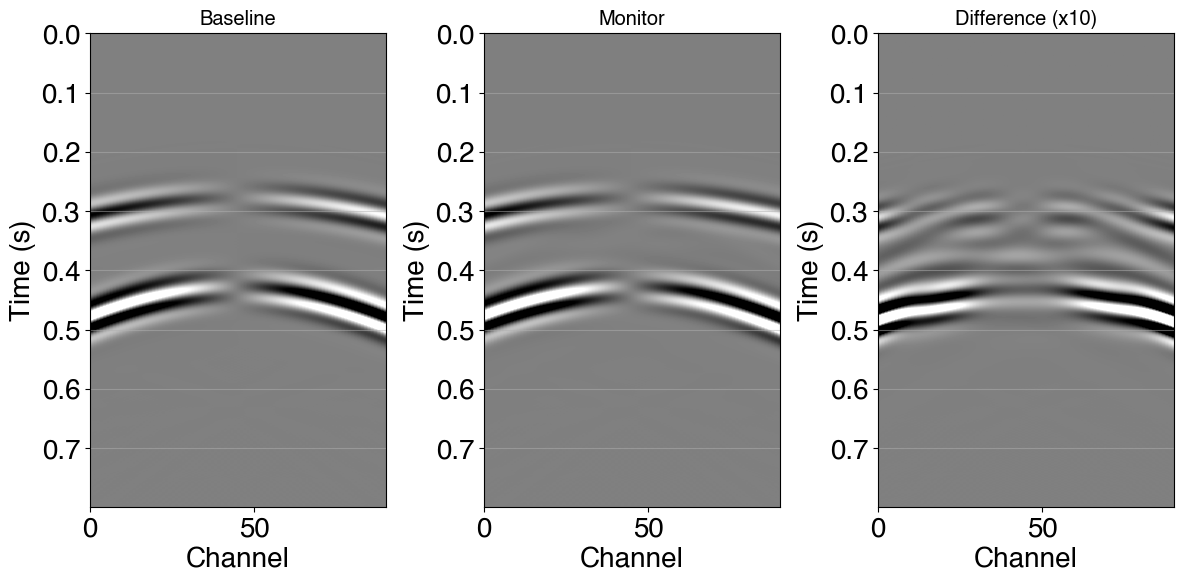

In [207]:
dobs_bl.plot_compare(dobs_ml, shotid=2, comp='vz', clip=99., ratio=10, 
                     title=['Baseline', 'Monitor', 'Difference'])

## FWI

In [208]:
# set the Gaussian smooth kernel size (estimated acoording to the data frequency band)
smooth_size = [1, 1]

# set the gradient preconditioning mask
grad_mask = np.ones((nz, nx), dtype=np.float32)
# grad_mask[:112,:] = 0.0
# grad_mask[ 157:,:] = 0.0
# grad_mask[:,:38] = 0.0
# grad_mask[:,213:] = 0.0

grad_mask = smooth2d(grad_mask, 5, 5)

In [209]:
# Create a seismic model
model_fwi = ElasticModel(ox, oz, dx, dz, nx, nz,
                     vp = vp_bl, 
                     vs = vs_bl,
                     rho = rho_bl,
                     vp_grad = True, 
                     vs_grad = True,
                     rho_grad = True,
                     vp_bound = [3000, 5000],
                     vs_bound = [1000, 3000],
                     rho_bound = [1000, 3000],
                     free_surface=False, 
                     mask = grad_mask,
                     smooth_size=smooth_size,
                    #  device='cuda',
                     nabc=20)


Smooth gradient is applied


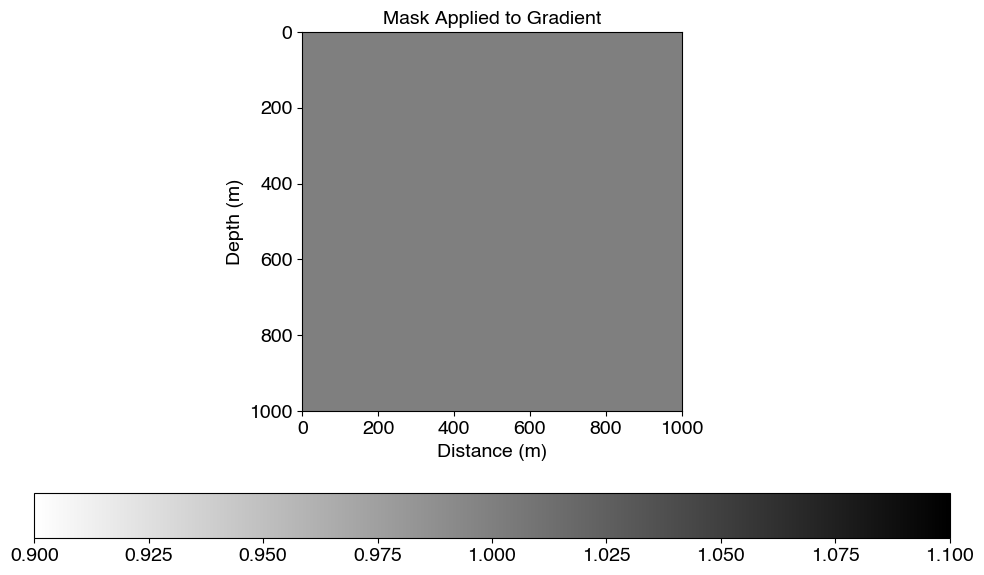

In [210]:
model_fwi.plot_mask()

In [211]:
# Setup propagator
F = ElasticPropagator(model_fwi, survey)

# Setup optimizer
optimizer = torch.optim.LBFGS(model_fwi.parameters(), lr = 0.1, max_iter = 1, 
                              tolerance_change = 1e-4, history_size = 5, 
                              line_search_fn = 'strong_wolfe' )

# Setup misfit function
# misfit = GCLoss
misfit = torch.nn.MSELoss()

# Setup log file
log_file = f'{path}/Elastic-FWI-ML.log'

# Setup components
weight = {'vx': 1.0, 
          'vz': 1.0}

# Setup acoustic FWI problem
fwi = ElasticFWI(F, model_fwi, optimizer, misfit, dobs_ml, weight)

Survey analysis completed: legal survey
free surface: False


In [212]:
fwi(nshot_per_gpu_per_batch = 4, max_iter = 30, grad_scale = 5.0, log_file=log_file)

**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :          1
***********************************************************

   Niter           fk                ngrad          max grad
     1       1.495227e+03                1         1.00e+00
     1       1.495227e+03                1         1.00e+00
     1       1.495227e+03                1         1.00e+00
     1       1.495227e+03                1         1.00e+00
     1       1.495227e+03                1         1.00e+00
     1       1.495227e+03                1         1.00e+00
     1       1.495227e+03                7         1.00e+00
     2       4.145499e+02                8         1.58e-01
     2       4.145499e+02                9         1.58e-01
     3       3.995498e+02               10         1.51e-01
     3       2.876357e+0

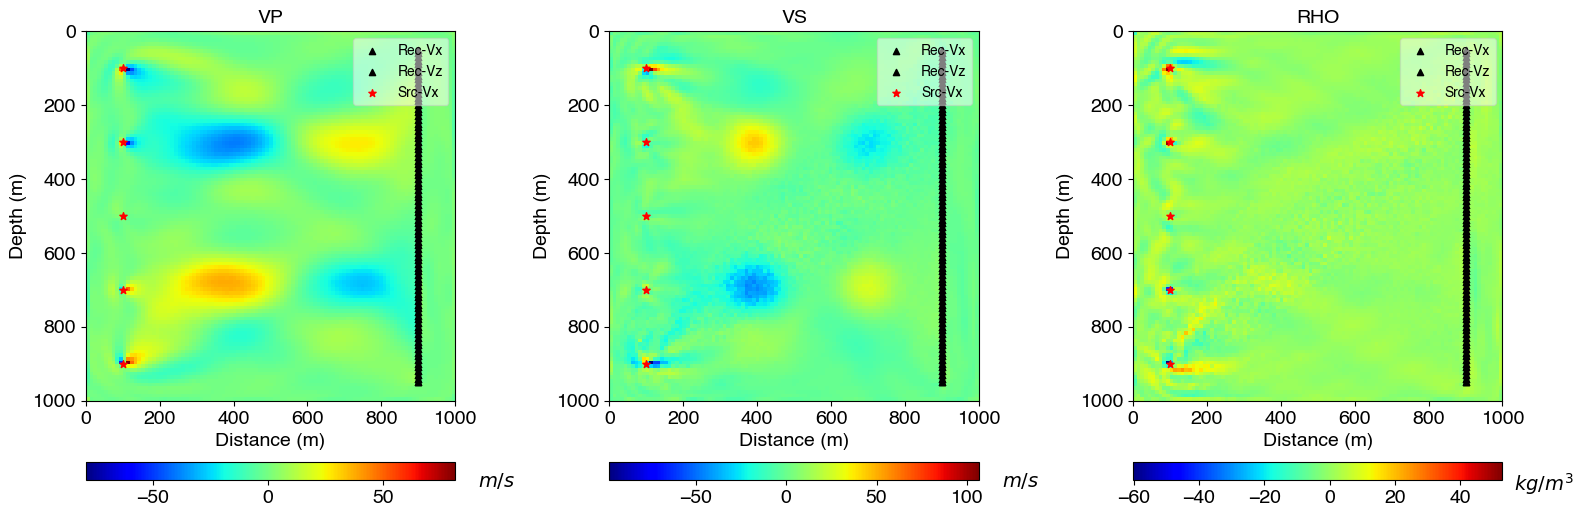

In [213]:
(model_fwi-model_bl).plot(survey, save_path=f'{path}/Figure/model_FWI_FD.pdf')

## Design the RBF model

In [214]:
theta_vp_int = np.zeros(len(rbf_center))
theta_vs_int = np.zeros(len(rbf_center))
theta_rho_int = np.zeros(len(rbf_center))

model_fwi_rbf = ElasticModelRBF(ox, oz, dx, dz, nx, nz, 
                           centers = rbf_center, 
                           theta_vp = theta_vp_int, 
                           theta_vs = theta_vs_int,
                           theta_rho = theta_rho_int,
                           sigma = sigma,
                           update_theta_vp = True,
                           update_theta_vs = True, 
                           update_theta_rho = True, 
                           vp = vp_bl,
                           vs = vs_bl,
                           rho = rho_bl,
                           vp_bound = [3000, 5000],
                           vs_bound = [1000, 3000],
                           rho_bound = [1000, 3000],
                           device='cuda')

In [215]:
# Setup propagator
F = ElasticPropagator(model_fwi_rbf, survey)

# Setup optimizer
optimizer = torch.optim.LBFGS(model_fwi_rbf.parameters(), lr = 0.1, max_iter = 1, 
                              tolerance_change = 1e-4, history_size = 5, 
                              line_search_fn = 'strong_wolfe' )

# Setup misfit function
# misfit = GCLoss
misfit = torch.nn.MSELoss()


# Setup log file
log_file_rbf = f'{path}/Elastic-FWI-ML-RBF.log'

# Setup components
weight = {'vx': 1.0, 
          'vz': 1.0}

# Setup acoustic FWI problem
fwi = ElasticFWI(F, model_fwi_rbf, optimizer, misfit, dobs_ml, weight)

fwi(nshot_per_gpu_per_batch = 8, max_iter = 50, grad_scale = 5.0, log_file=log_file_rbf)

Survey analysis completed: legal survey
free surface: False
**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :          1
***********************************************************

   Niter           fk                ngrad          max grad
     1       9.337144e+01                1         1.00e+00
     1       9.303411e+01                1         9.98e-01
     1       9.118917e+01                1         9.87e-01
     1       7.224458e+01                1         8.69e-01
     1       7.224458e+01                5         8.69e-01
     2       6.003642e+01                6         7.80e-01
     2       6.003642e+01                7         7.80e-01
     3       5.006797e+01                8         7.00e-01
     3       8.354969e+00                8         8.40e-02
     3       8.354969e+0

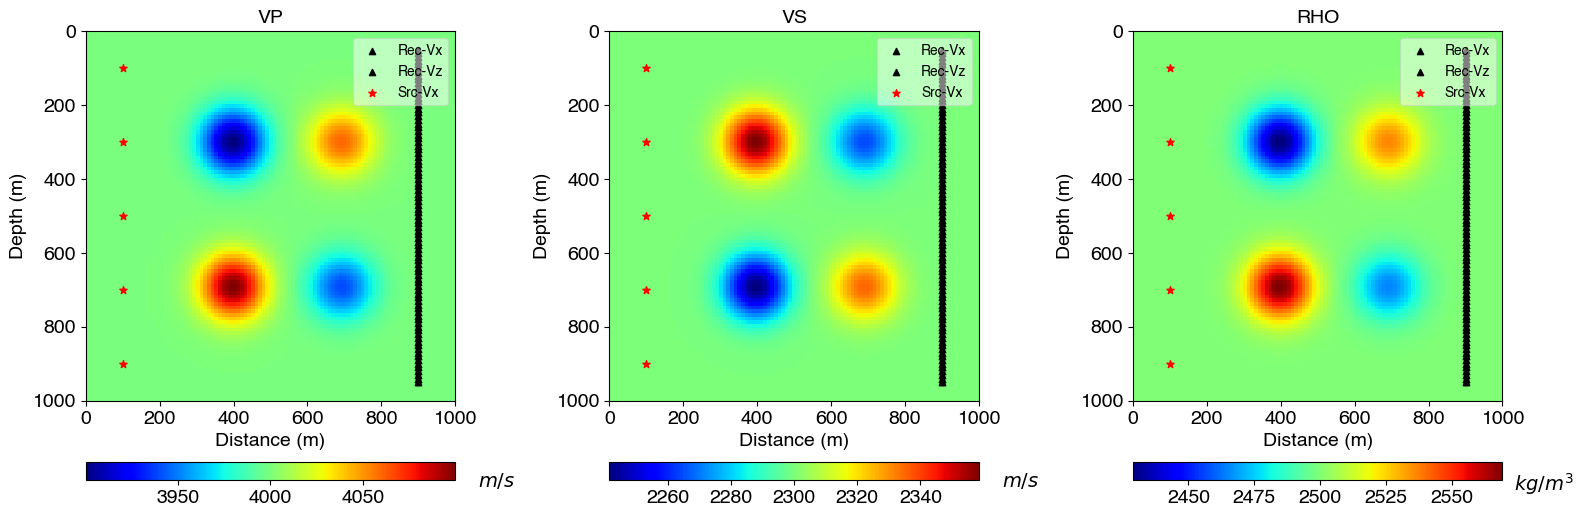

In [219]:
model_fwi_rbf.plot(survey, save_path=f'{path}/Figure/model_FWI_RBF.pdf')

In [220]:
print(model_fwi_rbf.theta_vp)
print(model_fwi_rbf.theta_vs)
print(model_fwi_rbf.theta_rho)


Parameter containing:
tensor([-100.0882,  100.2780,   59.9537,  -60.1885], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([ 58.7070, -58.7874, -35.3806,  35.3566], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-71.3017,  69.5855,  36.5454, -35.1620], device='cuda:0',
       requires_grad=True)


In [221]:
print(theta_vp_true)
print(theta_vs_true)
print(theta_rho_true)

[-100.  100.   60.  -60.]
[ 58.82352941 -58.82352941 -35.29411765  35.29411765]
[-66.66666667  66.66666667  40.         -40.        ]


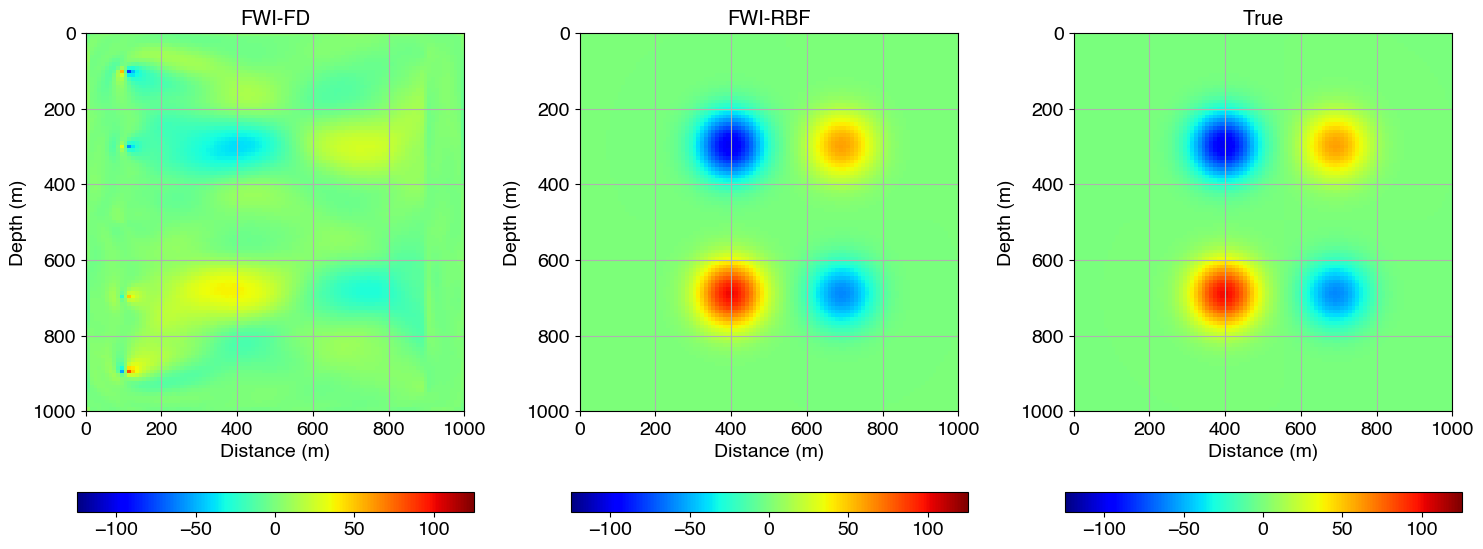

In [222]:
vp_fwi_rbf = model_fwi_rbf.get_model('vp') - vp_bl
vp_fwi_fd = model_fwi.get_model('vp') - vp_bl
vp_true = vp_ml - vp_bl

cassm_utils.plot_2d(x, z, [vp_fwi_fd, vp_fwi_rbf, vp_true], vmin=-125, vmax=125, 
                    cmap='jet', title=['FWI-FD', 'FWI-RBF','True'])

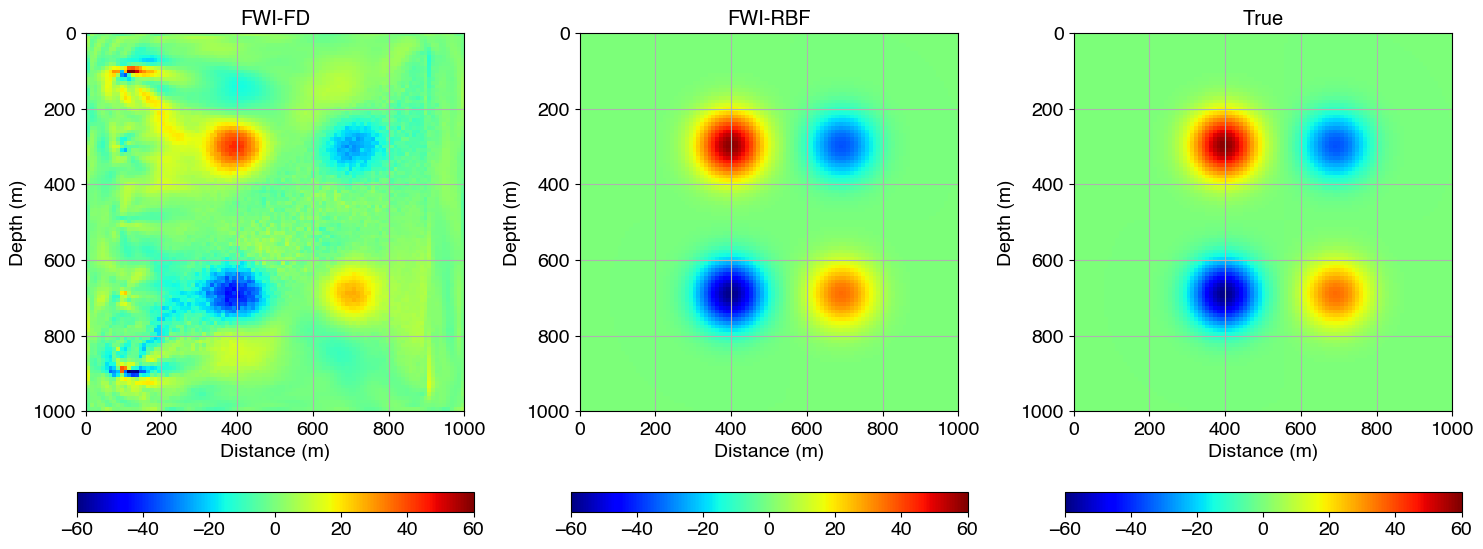

In [223]:
vs_fwi_rbf = model_fwi_rbf.get_model('vs') - vs_bl
vs_fwi_fd = model_fwi.get_model('vs') - vs_bl
vs_true = vs_ml - vs_bl

cassm_utils.plot_2d(x, z, [vs_fwi_fd, vs_fwi_rbf, vs_true], vmin=-60, vmax=60, 
                    cmap='jet', title=['FWI-FD', 'FWI-RBF','True'])

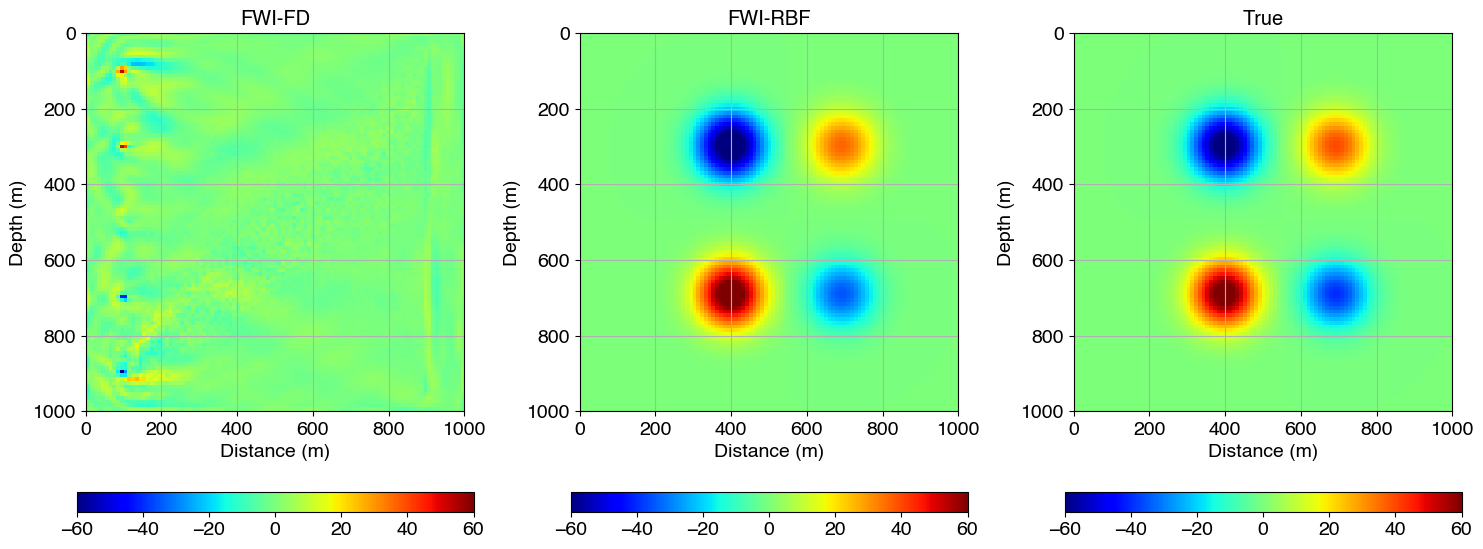

In [224]:
rho_fwi_rbf = model_fwi_rbf.get_model('rho') - rho_bl
rho_fwi_fd = model_fwi.get_model('rho') - rho_bl
rho_true = rho_ml - rho_bl

cassm_utils.plot_2d(x, z, [rho_fwi_fd, rho_fwi_rbf, rho_true], vmin=-60, vmax=60, 
                    cmap='jet', title=['FWI-FD', 'FWI-RBF','True'])

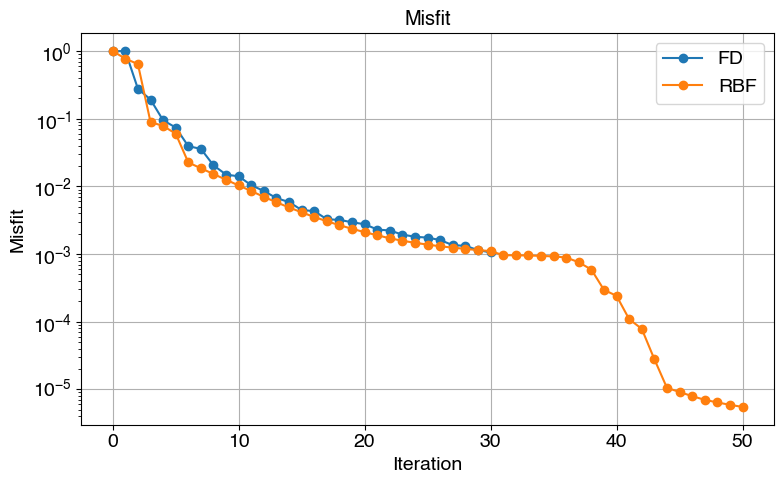

In [225]:
misfit_fd = load_misfit(f'{path}/Elastic-FWI-ML.log')
misfit_rbf = load_misfit(f'{path}/Elastic-FWI-ML-RBF.log')

plot_misfit([misfit_fd, misfit_rbf], label=['FD', 'RBF'], figname=f'{path}/Figure/misfit_compare.pdf')

## HMC Inference

In [226]:
# Setup initial model
theta_vp_int = np.zeros(len(rbf_center))
theta_vs_int = np.zeros(len(rbf_center))
theta_rho_int = np.zeros(len(rbf_center))

model_fwi_hmc = ElasticModelRBF(ox, oz, dx, dz, nx, nz, 
                           centers = rbf_center, 
                           theta_vp = theta_vp_int, 
                           theta_vs = theta_vs_int,
                           theta_rho = theta_rho_int,
                           sigma = sigma,
                           update_theta_vp = True,
                           update_theta_vs = True, 
                           update_theta_rho = True, 
                           vp = vp_bl,
                           vs = vs_bl,
                           rho = rho_bl,
                           vp_bound = [3000, 5000],
                           vs_bound = [1000, 3000],
                           rho_bound = [1000, 3000],
                           device='cuda',
                           set_as_par=False
                           )

# Setup propagator
F = ElasticPropagator(model_fwi_hmc, survey)

# Setup the misfit
misfit = torch.nn.MSELoss()

# Setup components
weight = {'vx': 1.0, 
          'vz': 1.0}

# Setup annealing temperature
temp = 1e-10

# Setup FWI likelihood
fwi_likelihood = AcousticLikelihood(F, model_fwi_hmc, misfit, dobs_ml, weight, temp=temp)

Survey analysis completed: legal survey
free surface: False


In [227]:
# Define the prior
dtype  = fwi_likelihood.model.vp.dtype
device = fwi_likelihood.model.vp.device
ndim   = fwi_likelihood.model.get_ndim()

prior_mean_vp  = model_fwi_rbf.theta_vp.cpu().detach().numpy()
prior_mean_vs  = model_fwi_rbf.theta_vs.cpu().detach().numpy()
prior_mean_rho = model_fwi_rbf.theta_rho.cpu().detach().numpy()

prior_std_vp  = np.ones_like(prior_mean_vp) * 40.0
prior_std_vs  = np.ones_like(prior_mean_vs) * 40.0/1.73
prior_std_rho = np.ones_like(prior_mean_rho) * 40.0
prior_mean = np.concatenate((prior_mean_vp.flatten(), prior_mean_vs.flatten(), prior_mean_rho.flatten()))
prior_std = np.concatenate((prior_std_vp.flatten(), prior_std_vs.flatten(), prior_std_rho.flatten()))

prior = GaussianPrior(prior_mean, prior_std, ndim, dtype, device)

prior

Independent(Normal(loc: torch.Size([12]), scale: torch.Size([12])), 1)

In [228]:
model_fwi_hmc.get_ndim()

12

In [229]:
# Define the Inference problem
pars = {}
pars['rng_seed'] = 1
pars['num_warmup'] = 200
pars['num_samples'] = 5000
pars['step_size'] = 0.0001
pars['num_steps'] = 10
pars['adapt_step_size'] = True
pars['adapt_mass_matrix'] = False
pars['target_accept_prob'] = 0.65

inference = AcousticInference(pars, fwi_likelihood, prior, method='hmc', save_path=path)

inference

AcousticInference
Method: hmc
Prior: Independent(Normal(loc: torch.Size([12]), scale: torch.Size([12])), 1)
Save Path: AGU-Elastic-Simple
Parameters:
	       rng_seed: 1
	     num_warmup: 200
	    num_samples: 5000
	      step_size: 0.0001
	      num_steps: 10
	adapt_step_size: True
	adapt_mass_matrix: False
	target_accept_prob: 0.65

In [230]:
posterior, log_prob = inference(compute_log_prob=True)

******** Acoustic Inference Running ********



Warmup:   0%|          | 2/5200 [00:05,  2.24s/it, step size=1.29e+02, acc. prob=0.500]

Penalty is applied for vp
Penalty is applied for vs
Penalty is applied for rho


Warmup:   0%|          | 3/5200 [00:05,  1.31s/it, step size=2.09e+01, acc. prob=0.333]

Penalty is applied for vs


Sample: 100%|██████████| 5200/5200 [11:23,  7.61it/s, step size=1.45e+01, acc. prob=0.755]


Computing log probability ...


  0%|          | 0/5000 [00:00<?, ?it/s]


Inference Results saved to AGU-Elastic-Simple/FWI-hmc-num-5000-temp-1e-10.nc

******** Acoustic Inference Done ********


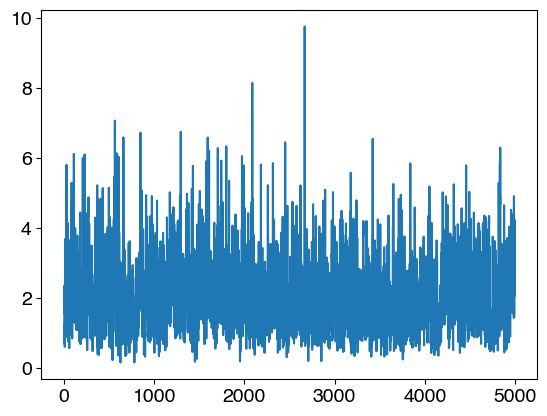

In [231]:
plt.plot(-log_prob)

In [232]:
map_indx = np.argmax(log_prob)

In [233]:
prior_rbf = prior.sample((pars['num_samples'],)).cpu().numpy()

## Analyze the posterior

In [234]:
posterior_az = az.from_pyro(posterior, log_likelihood=False)

In [235]:
posterior_az

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

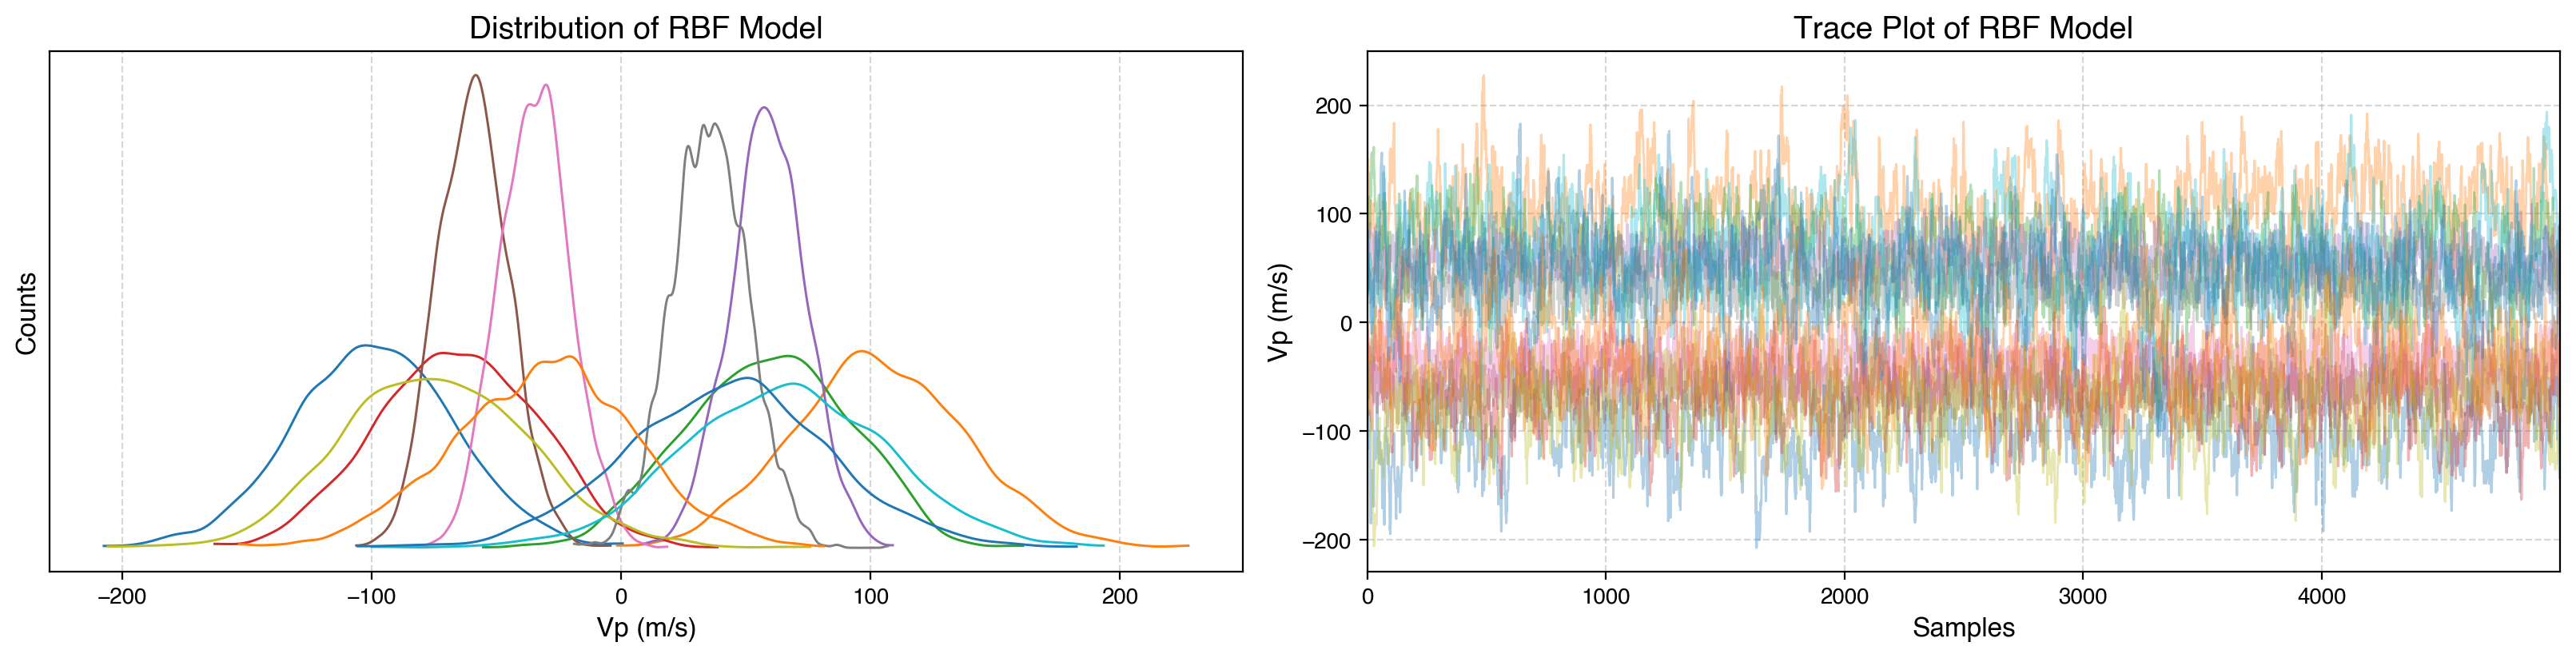

In [326]:
plots.plot_trace(posterior_az, save_path=f'{path}/Figure/traceplot.pdf')


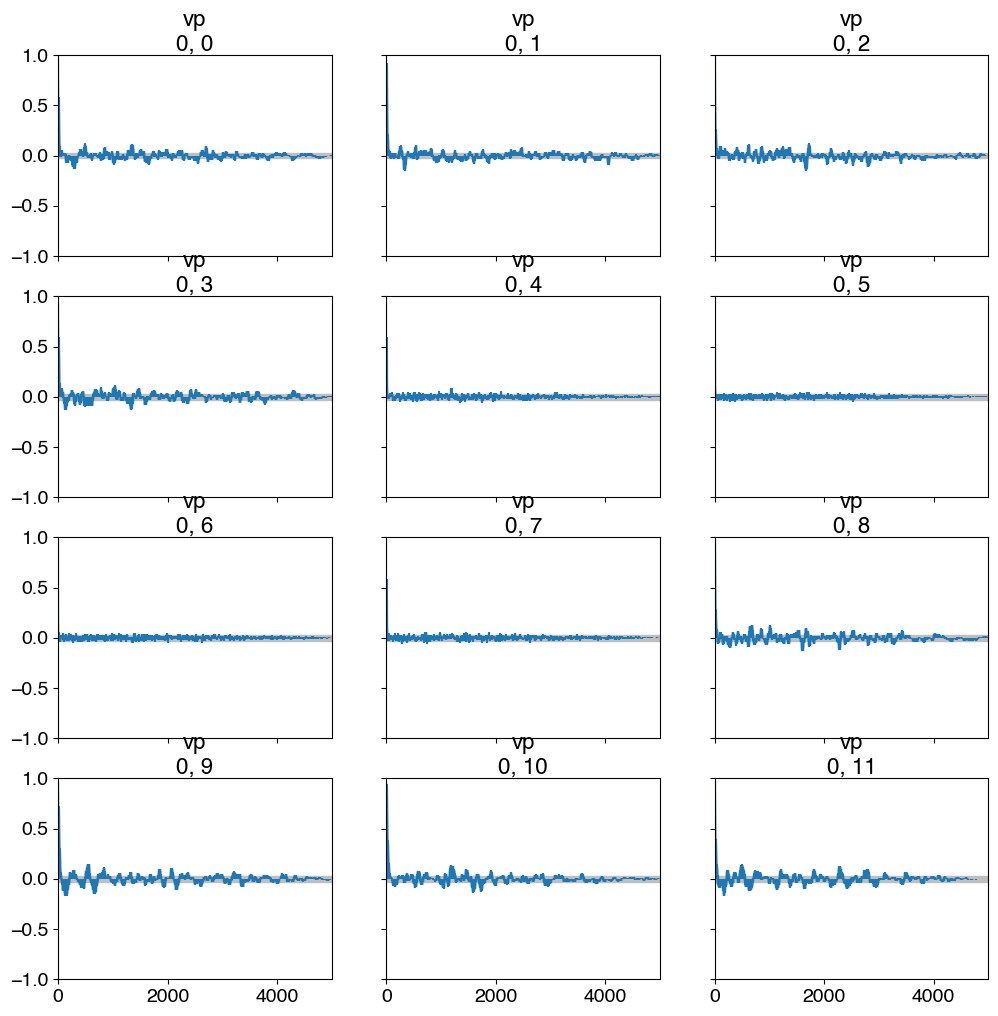

In [237]:
plots.plot_autocorr(posterior_az, pars)

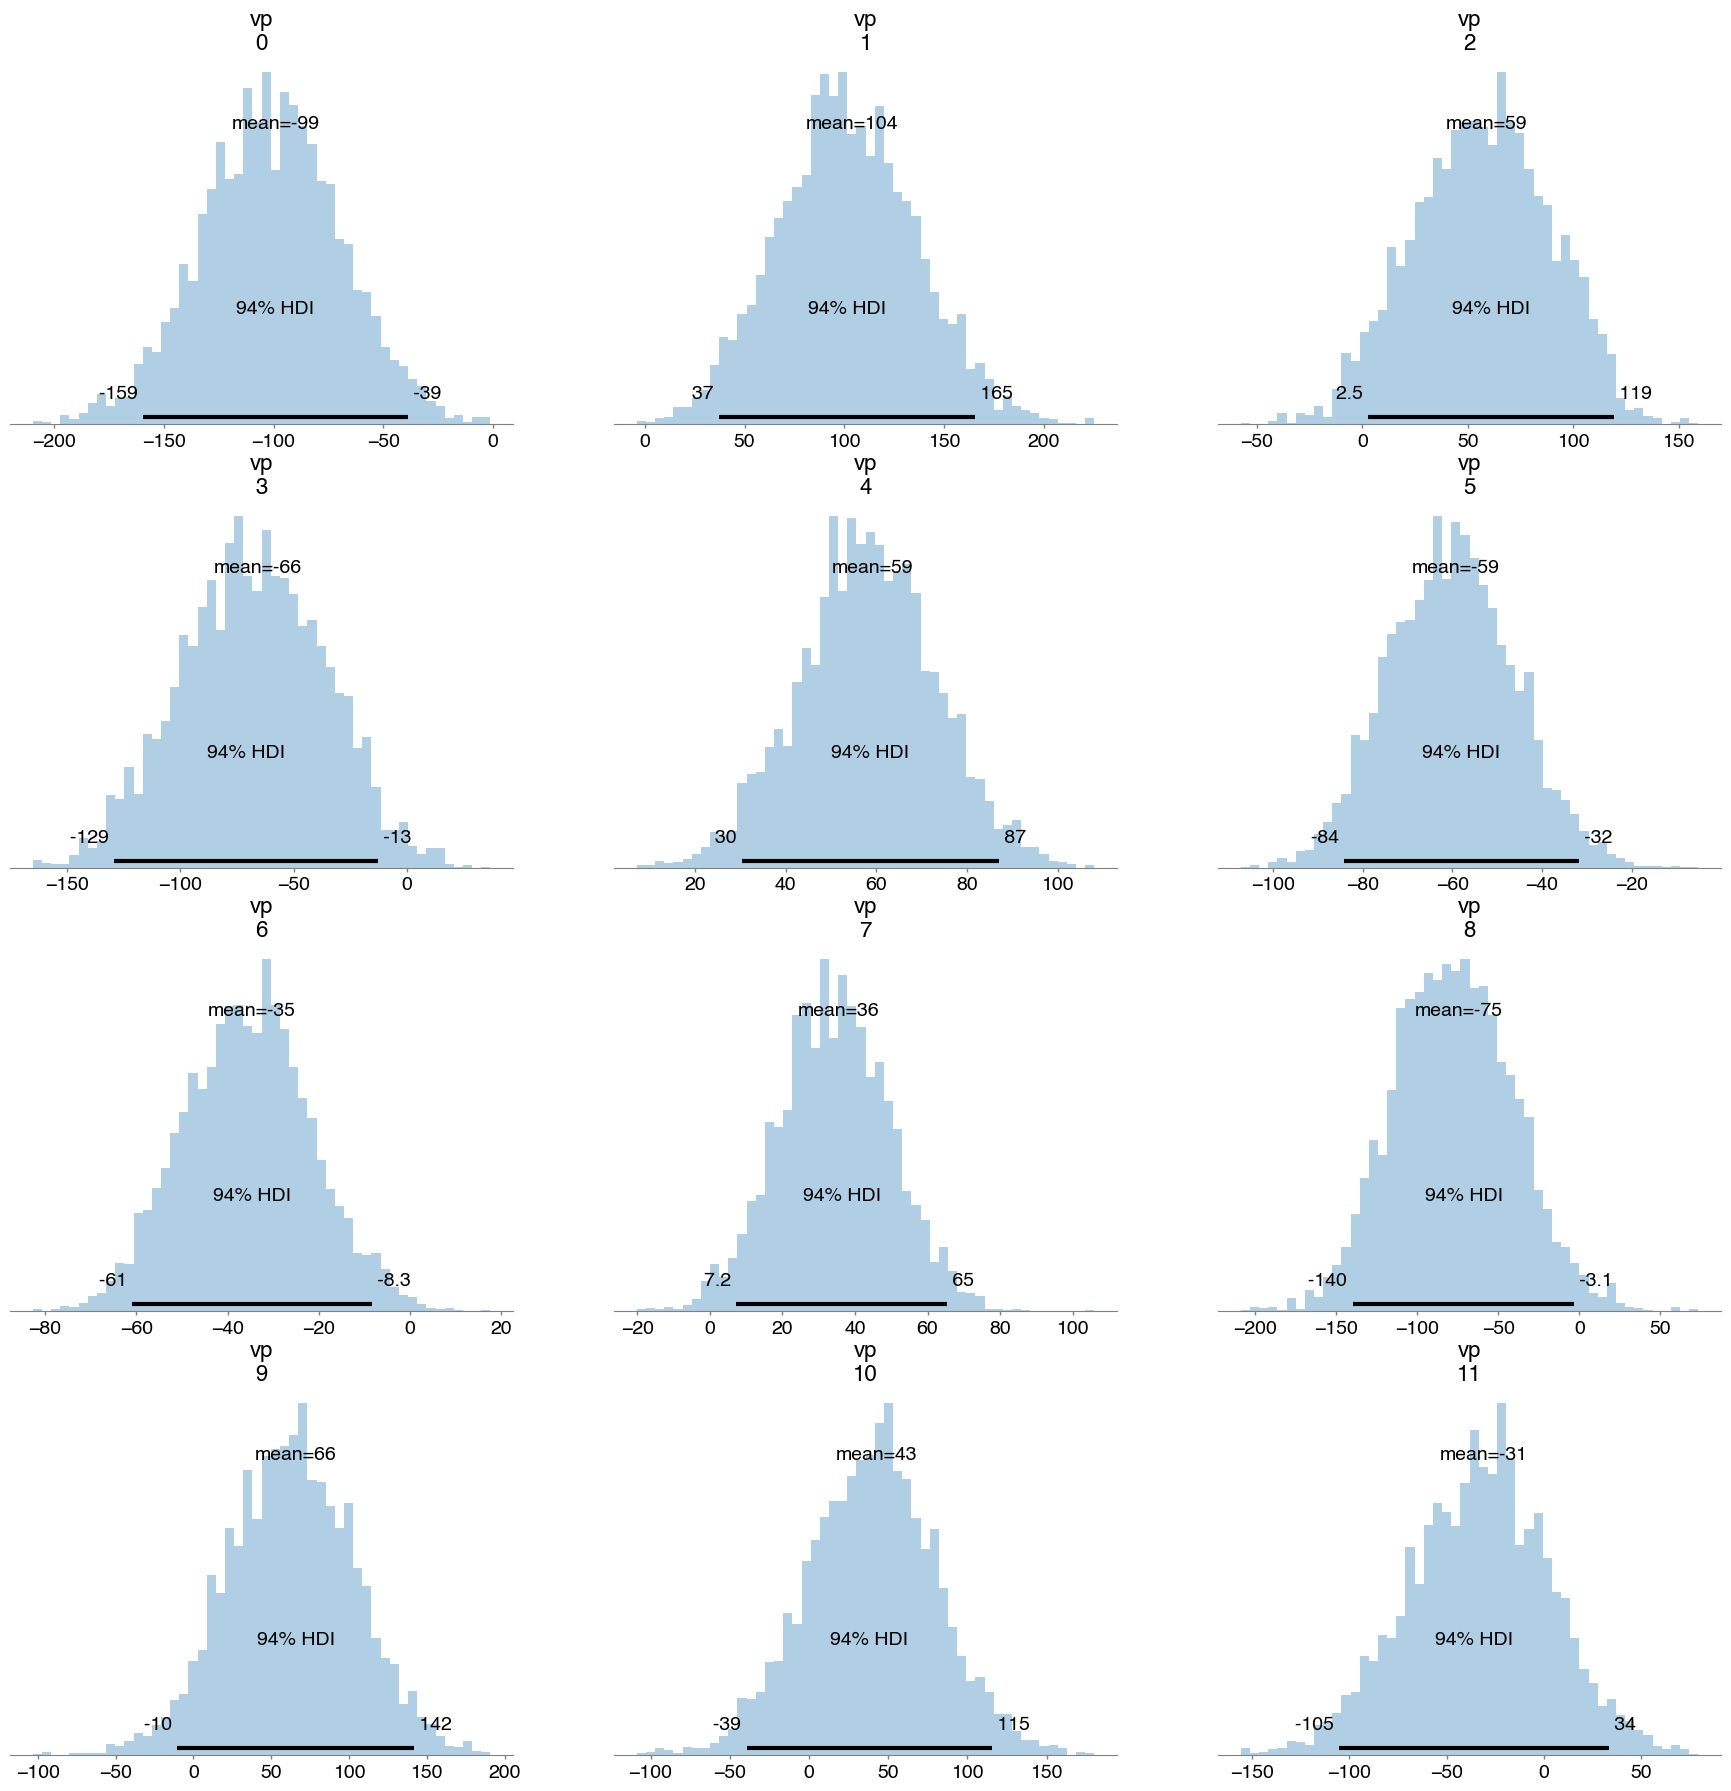

In [246]:
# Trace histograms
az.plot_posterior(posterior_az, kind='hist', bins=50)
plt.show()

### Compute Statistics

In [238]:
# extract the posterior samples as numpy array
chain = 0
posterior_rbf = posterior_az.posterior['vp'].values[chain]


In [239]:
posterior_vp, posterior_vs, posterior_rho = model_fwi_rbf.convert_rbf_to_model(posterior_rbf, batch_size=200)

  0%|          | 0/25 [00:00<?, ?it/s]

In [240]:
rbf_mean = np.mean(posterior_rbf, axis=0)
rbf_std  = np.std(posterior_rbf, axis=0)
rbf_med  = np.median(posterior_rbf, axis=0)

vp_mean = np.mean(posterior_vp, axis=0)
vp_std  = np.std(posterior_vp, axis=0)
vp_med  = np.median(posterior_vp, axis=0)

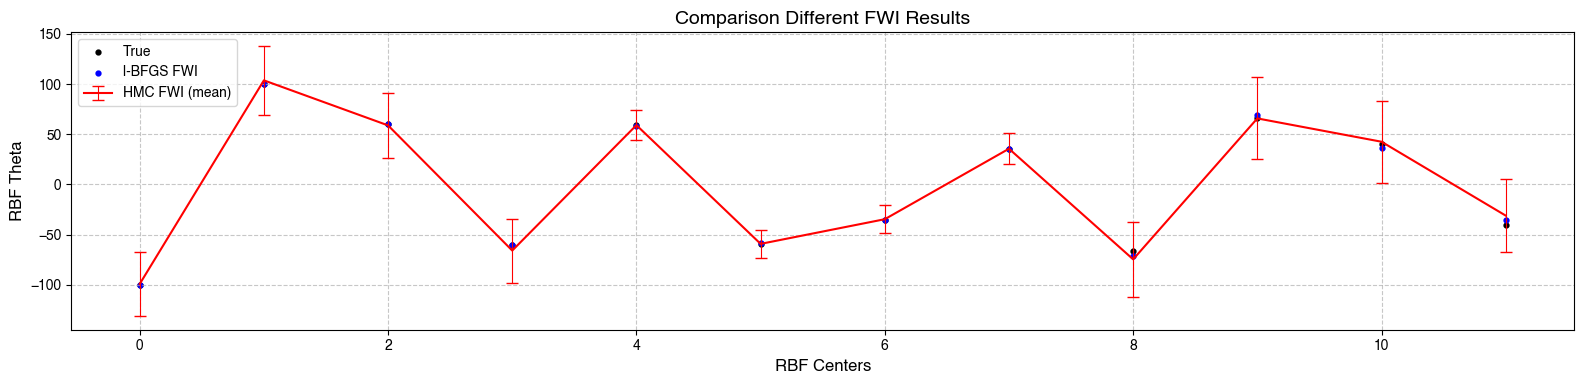

In [241]:
rbf_x = np.arange(len(rbf_center) * 3)
rbf_true = np.concatenate((theta_vp_true, theta_vs_true, theta_rho_true))
rbf_fwi= np.concatenate((model_fwi_rbf.theta_vp.cpu().detach().numpy(),
                            model_fwi_rbf.theta_vs.cpu().detach().numpy(),
                            model_fwi_rbf.theta_rho.cpu().detach().numpy()))


plt.figure(figsize=(16, 4), dpi=100)
plt.scatter(rbf_x, rbf_true, label='True', marker='.', color='k', linewidth=1.5)
plt.scatter(rbf_x, rbf_fwi, label='l-BFGS FWI', marker='.', color='blue', linewidth=1.5)
plt.errorbar(rbf_x, rbf_mean, yerr=rbf_std, linestyle='-', color='red', label='HMC FWI (mean)', capsize=4, elinewidth=0.8)
# plt.plot(rbf_x, rbf_med, linestyle='-', color='Orange', label='HMC FWI (median)')

plt.legend(loc='upper left', fontsize=10)
plt.title('Comparison Different FWI Results', fontsize=14)
plt.xlabel('RBF Centers', fontsize=12)
plt.ylabel('RBF Theta', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.xlim([125, 280])

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()


## Figure1

array([[900.,  50.],
       [900.,  60.],
       [900.,  70.],
       [900.,  80.],
       [900.,  90.],
       [900., 100.],
       [900., 110.],
       [900., 120.],
       [900., 130.],
       [900., 140.],
       [900., 150.],
       [900., 160.],
       [900., 170.],
       [900., 180.],
       [900., 190.],
       [900., 200.],
       [900., 210.],
       [900., 220.],
       [900., 230.],
       [900., 240.],
       [900., 250.],
       [900., 260.],
       [900., 270.],
       [900., 280.],
       [900., 290.],
       [900., 300.],
       [900., 310.],
       [900., 320.],
       [900., 330.],
       [900., 340.],
       [900., 350.],
       [900., 360.],
       [900., 370.],
       [900., 380.],
       [900., 390.],
       [900., 400.],
       [900., 410.],
       [900., 420.],
       [900., 430.],
       [900., 440.],
       [900., 450.],
       [900., 460.],
       [900., 470.],
       [900., 480.],
       [900., 490.],
       [900., 500.],
       [900., 510.],
       [900.,

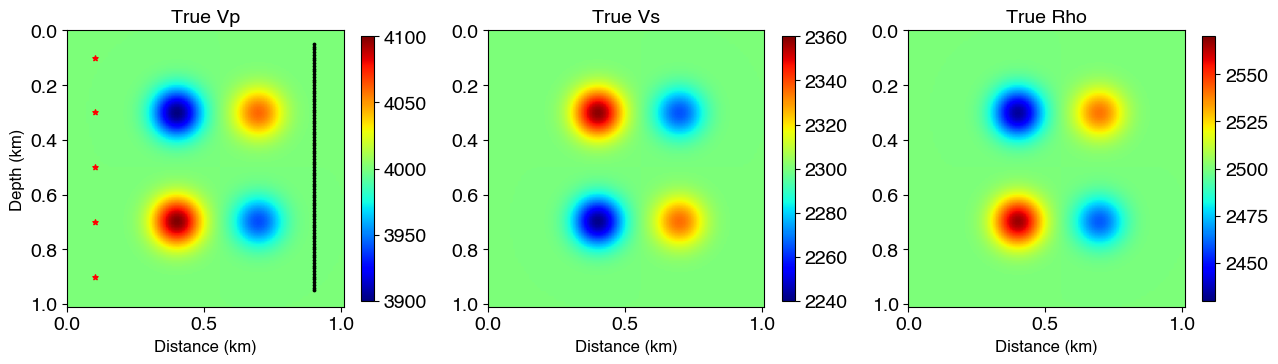

In [300]:
# Plot the true model

fig, axs = plt.subplots(1, 3, figsize=(13, 4), dpi=100)

extent = [ox, nx * dx/1000, nz * dz/1000, oz]

im=axs[0].imshow(vp_ml, cmap='jet', vmin=3900, vmax=4100, aspect='equal', extent=extent)
axs[0].set_title('True Vp', fontsize=14)
axs[0].set_xlabel('Distance (km)', fontsize=12)
axs[0].set_ylabel('Depth (km)', fontsize=12)
axs[0].set_aspect('equal')
cbar = plt.colorbar(im, ax=axs[0], orientation='vertical', pad=0.05, shrink=0.75)

# plot source and receiver
src_coord = source.get_loc()
rec_coord = geophone.get_loc('vx')

axs[0].scatter(rec_coord[:,0]/1000, rec_coord[:,1]/1000, s=3,  c='k')
axs[0].scatter(src_coord[:,0]/1000, src_coord[:,1]/1000, s=15, c='r', marker='*')

im=axs[1].imshow(vs_ml, cmap='jet', vmin=2240, vmax=2360, aspect='equal', extent=extent)
axs[1].set_title('True Vs', fontsize=14)
axs[1].set_xlabel('Distance (km)', fontsize=12)
# axs[1].set_ylabel('Depth (km)', fontsize=12)
cbar = plt.colorbar(im, ax=axs[1], orientation='vertical', pad=0.05, shrink=0.75)

im=axs[2].imshow(rho_ml, cmap='jet', vmin=2430, vmax=2570, aspect='equal', extent=extent)
axs[2].set_title('True Rho', fontsize=14)
axs[2].set_xlabel('Distance (km)', fontsize=12)
# axs[2].set_ylabel('Depth (km)', fontsize=12)
cbar = plt.colorbar(im, ax=axs[2], orientation='vertical', pad=0.05, shrink=0.75)

plt.tight_layout()
plt.savefig(f'{path}/Figure/true_model.pdf', dpi=300, bbox_inches='tight')
plt.show()


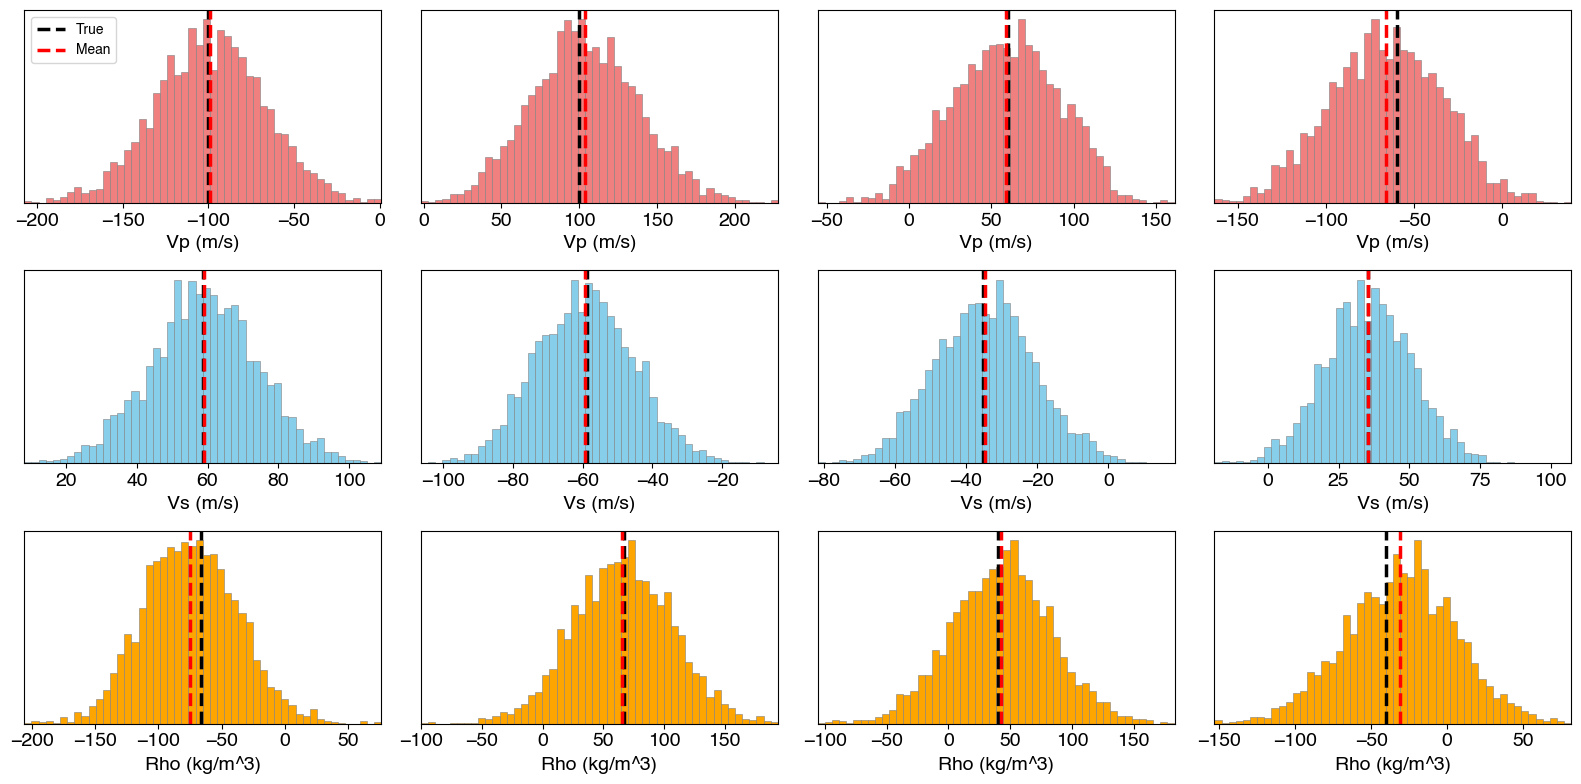

In [256]:
# Create figure and gridspec
fig = plt.figure(figsize=(16, 8))
grid = fig.add_gridspec(3, 4)

# Vp 
for i in range(12):
    
    ii = i // 4
    jj = i % 4
    
    colors=['lightcoral', 'skyblue', 'orange']
    xlables = ['Vp (m/s)', 'Vs (m/s)', 'Rho (kg/m^3)']
    ax = fig.add_subplot(grid[ii, jj])
    param = posterior_rbf[:,i]
    ax.hist(param, bins=50, color=colors[ii], edgecolor='gray', linewidth=0.4) # skyblue
    ax.set_xlim(param.min(), param.max())
    # ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xlables[ii], fontsize=14)

    ax.axvline(rbf_true[i], color='k', linestyle='--', linewidth=2.5, label='True')
    ax.axvline(np.mean(param), color='r', linestyle='--', linewidth=2.5, label='Mean')
    
    if i == 0:
        ax.legend(loc='upper left', fontsize=10)
        

plt.tight_layout()
plt.savefig(f'{path}/Figure/posterior_rbf.pdf', dpi=300, bbox_inches='tight')
plt.show()
 

/sep/haipeng/miniconda3/envs/pytorch/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


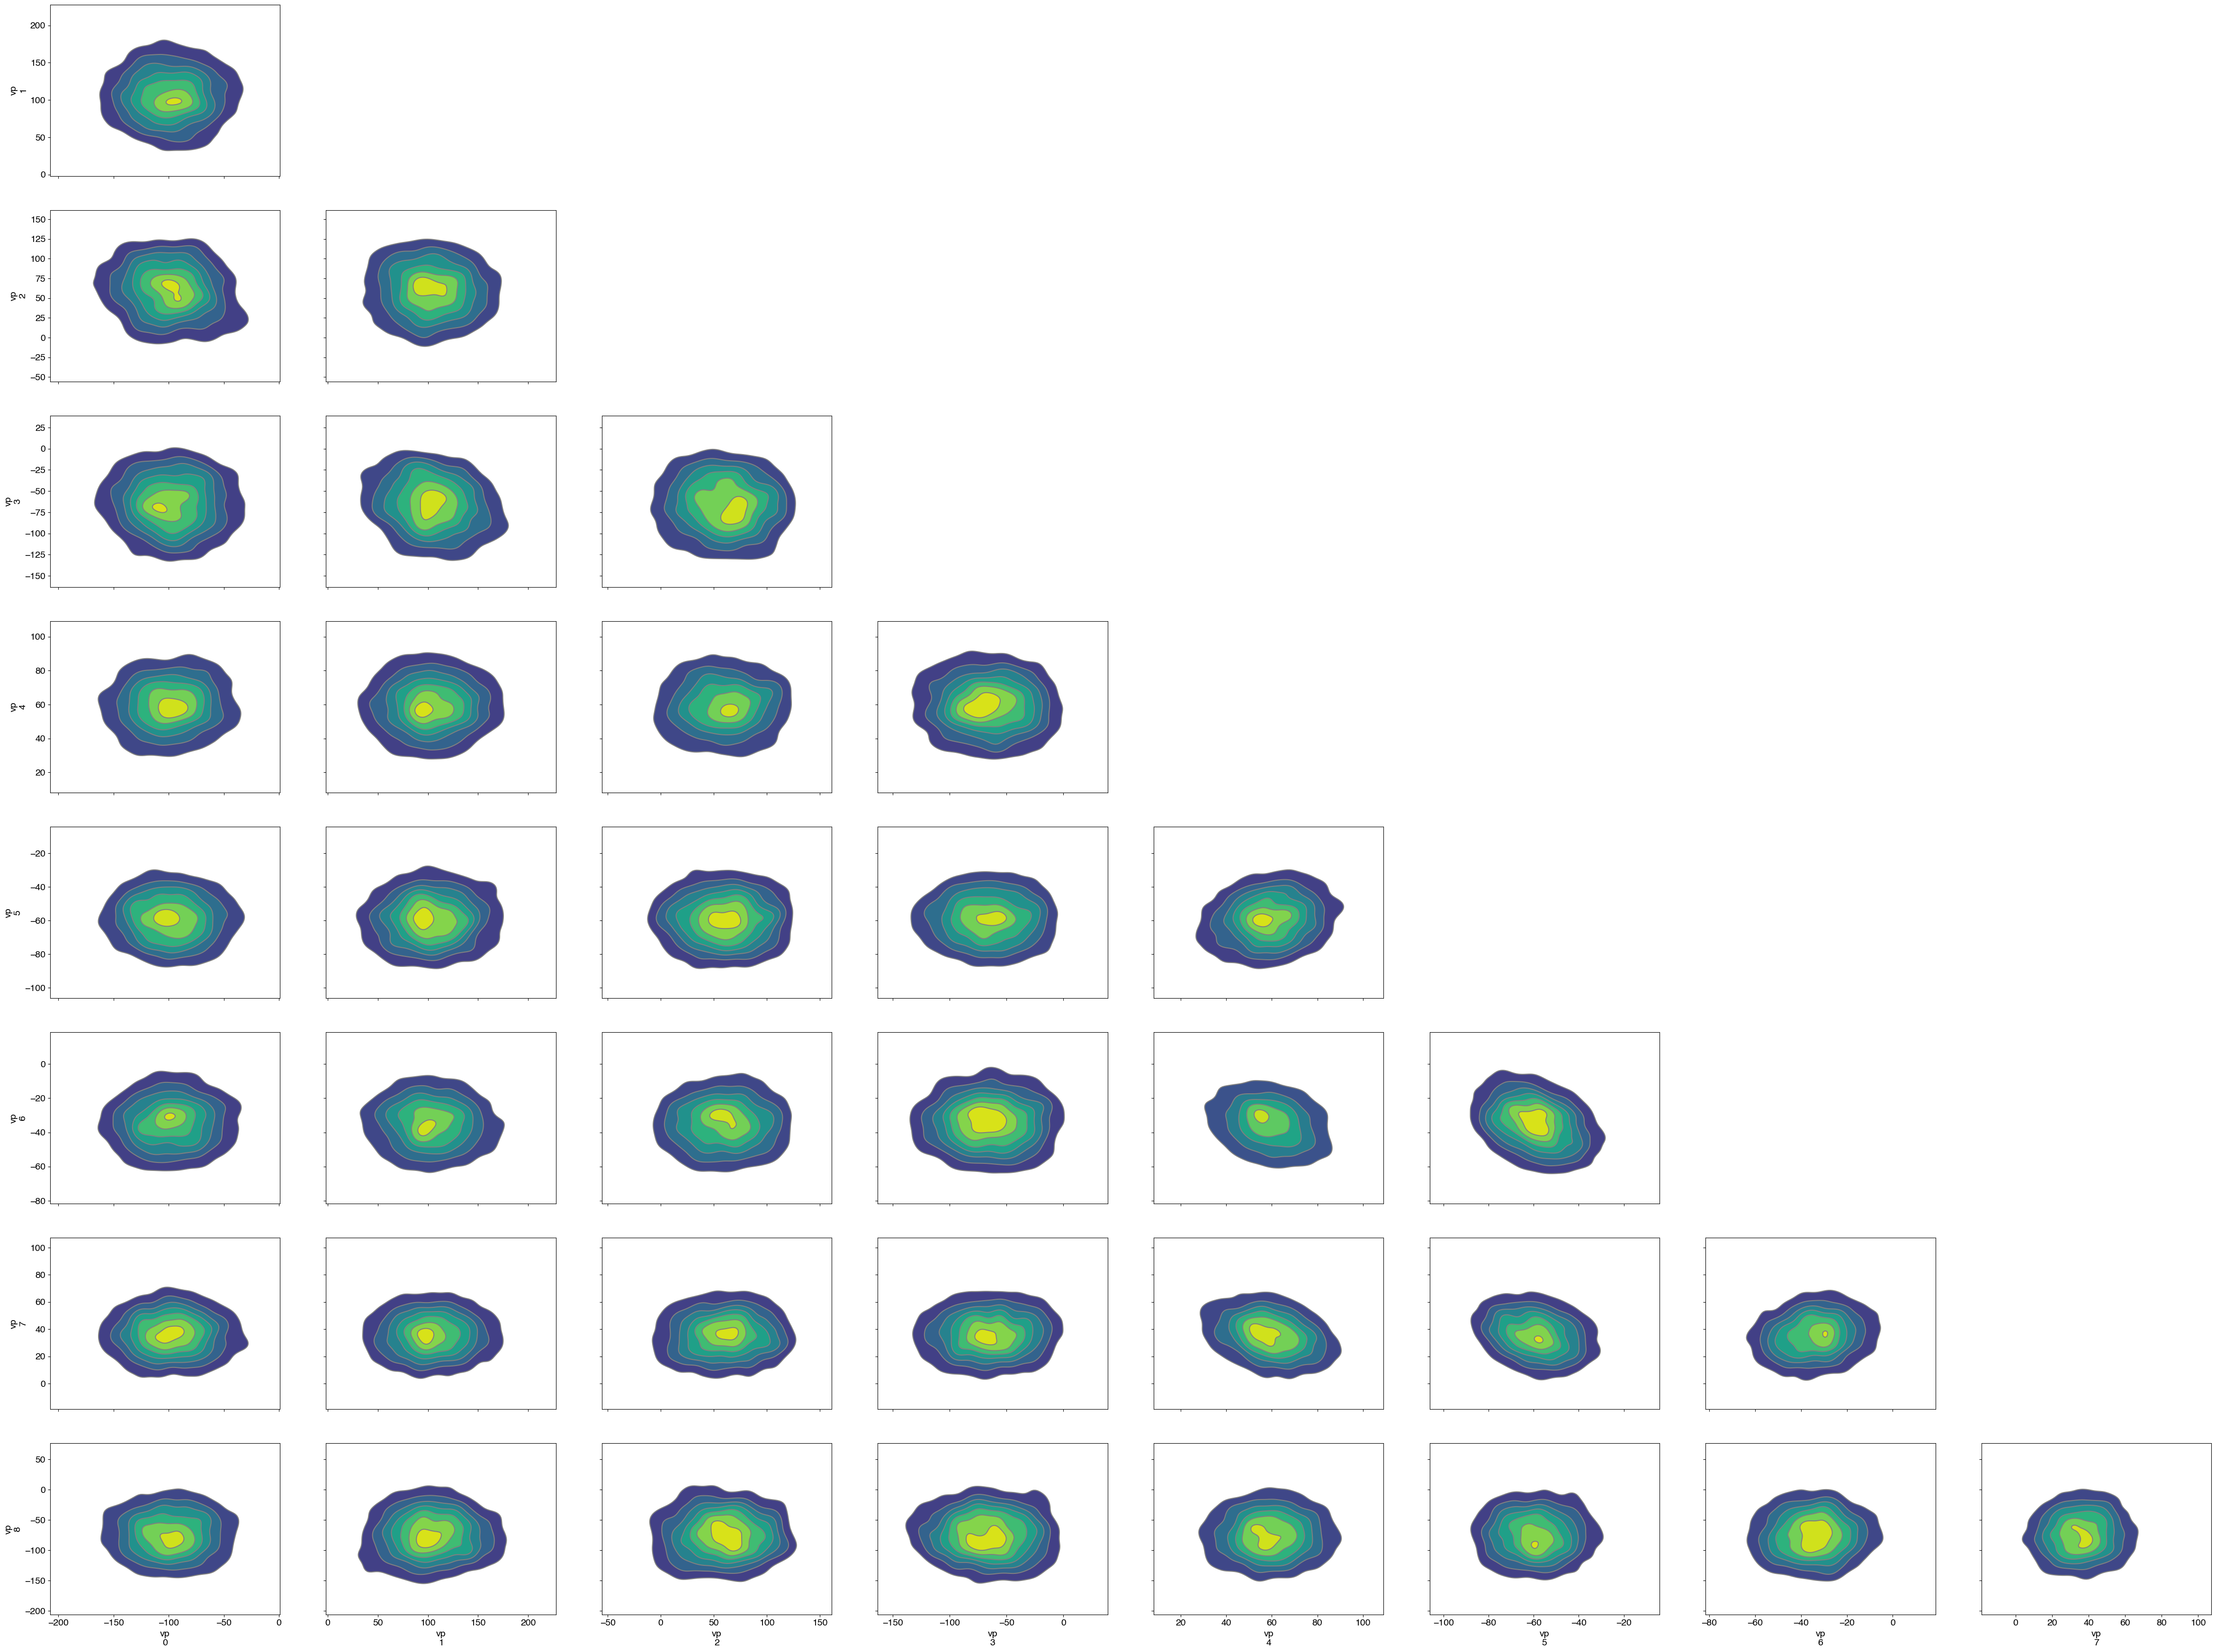

In [243]:
# Cross-plots
az.plot_pair(posterior_az, var_names=['vp'], kind='kde')
# plt.savefig(f"{path}/Figure/FWI-HMC-Distribution.pdf", dpi=300)
plt.show()

In [244]:
posterior_rbf.shape

(5000, 12)

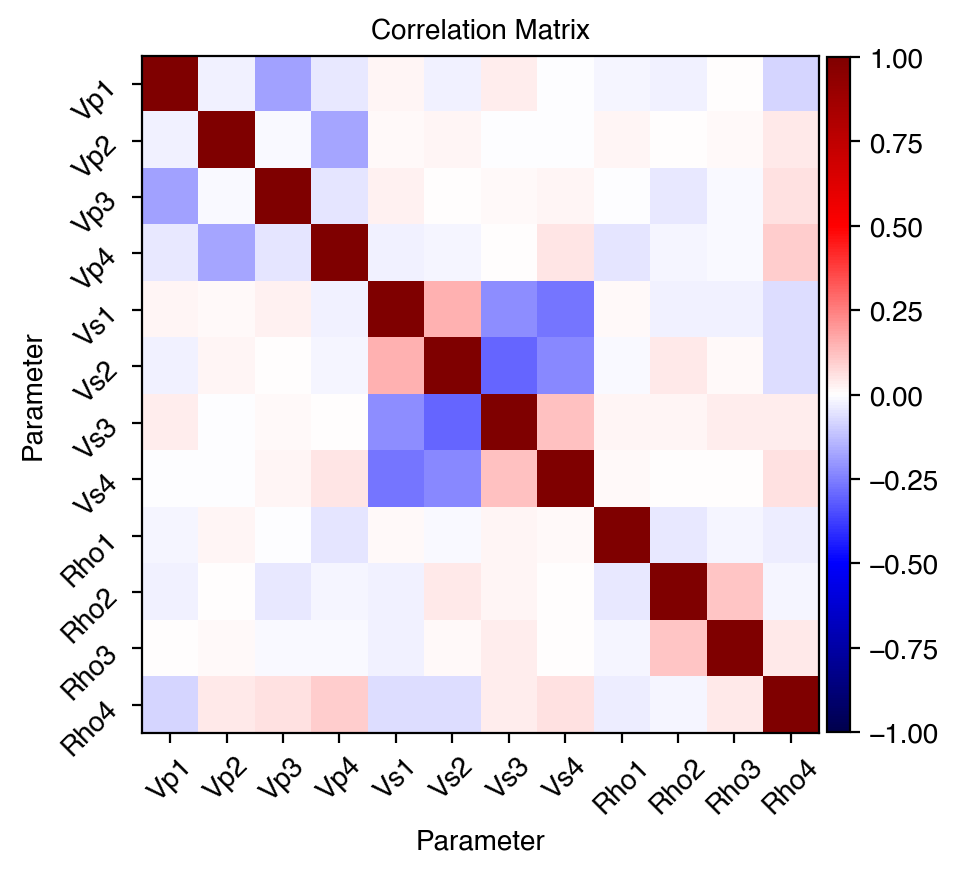

In [325]:
corr_matrix = np.corrcoef(posterior_rbf.reshape(posterior_rbf.shape[0], -1), rowvar=False)
font_size = 10
# Visualize the correlation matrix
plt.figure(figsize=(5, 5), dpi=200)
plt.imshow(corr_matrix, cmap="seismic", interpolation="nearest", vmin=-1, vmax=1, aspect="equal")
ticks = np.arange(0, 12, 1)
plt.xticks(ticks)
plt.yticks(ticks)
plt.xticks(ticks, labels=[f'Vp{i+1}' for i in range(4)] + [f'Vs{i+1}' for i in range(4)] + [f'Rho{i+1}' for i in range(4)], rotation=45, fontsize=font_size)
plt.yticks(ticks, labels=[f'Vp{i+1}' for i in range(4)] + [f'Vs{i+1}' for i in range(4)] + [f'Rho{i+1}' for i in range(4)], rotation=45, fontsize=font_size)
plt.title("Correlation Matrix", fontsize=font_size)
plt.xlabel("Parameter", fontsize=font_size)
plt.ylabel("Parameter", fontsize=font_size)
# set font size of colorbar
cbar = plt.colorbar(aspect=30, pad=0.01, shrink=0.78)
cbar.ax.tick_params(labelsize=font_size)

plt.tight_layout()
plt.savefig(f'{path}/Figure/corr_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plots.plot_dist(posterior_vp, [1000, 1100], [1000+1*dx, 1100], dx, bins=40, vp_true=vp_true, save_path=f'{path}/Figure/FWI-HMC-Results-Dist1.pdf')

In [ ]:
plots.plot_dist(posterior_vp, [1000, 1100], [1000+8*dx, 1100], dx, bins=40, vp_true=vp_true, save_path=f'{path}/Figure/FWI-HMC-Results-Dist2.pdf')